Enter the name of the dataset file (CSV):  iris.csv


Successfully loaded dataset: iris.csv
Auto-detected target column: 'species'

Target column detected: 'species'
Number of features: 4, Number of samples: 150

DATA SANITY CHECK REPORT
Shape of the dataset: (150, 5)
Memory usage: 0.01 MB

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB

Missing Values Analysis:
No missing values found.

Duplicate rows: 3
(2.00% of total data)

CATEGORICAL DISTRIBUTIONS

'species' — 3 unique value(s)
species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


Would you like to see EDA graphs? (yes/no):  yes



EXPLORATORY DATA ANALYSIS

Numerical Columns Summary:
       sepal_length  sepal_width  petal_length  petal_width
count        150.00       150.00        150.00       150.00
mean           5.84         3.05          3.76         1.20
std            0.83         0.43          1.76         0.76
min            4.30         2.00          1.00         0.10
25%            5.10         2.80          1.60         0.30
50%            5.80         3.00          4.35         1.30
75%            6.40         3.30          5.10         1.80
max            7.90         4.40          6.90         2.50

Categorical Columns Summary:
       species
count      150
unique       3
top     setosa
freq        50

Displaying EDA graphs...


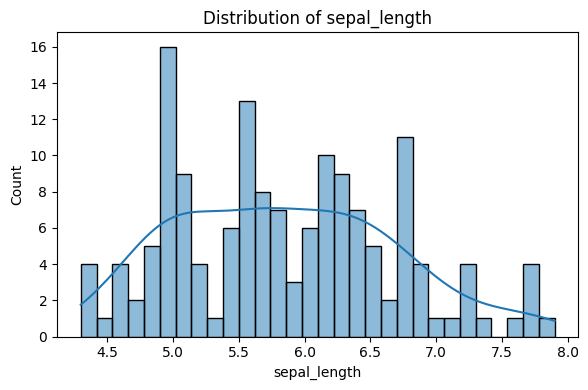

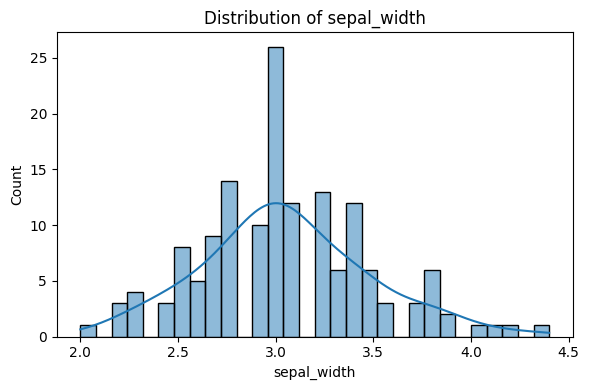

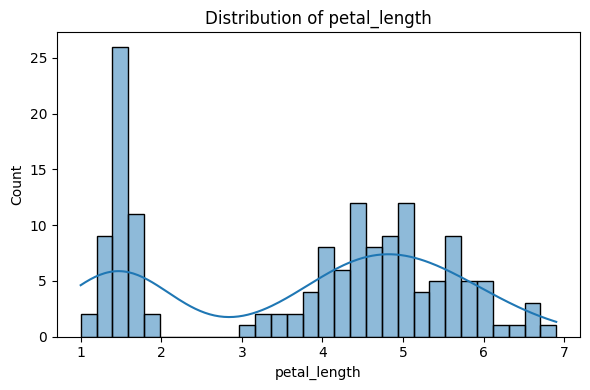

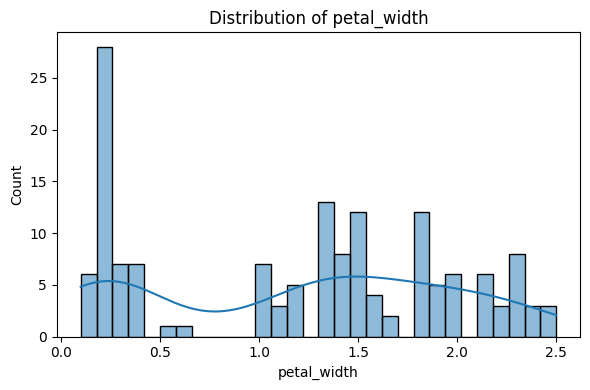

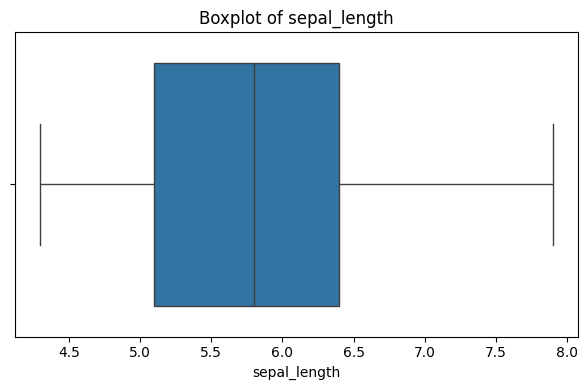

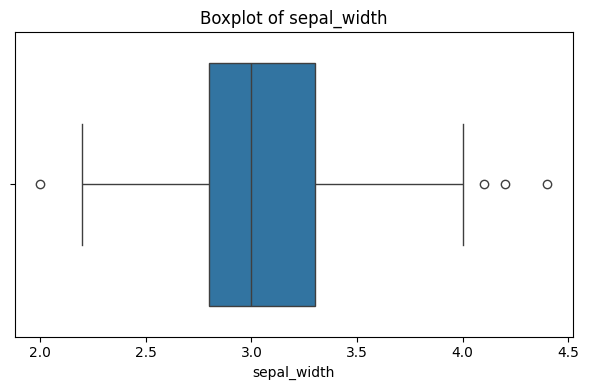

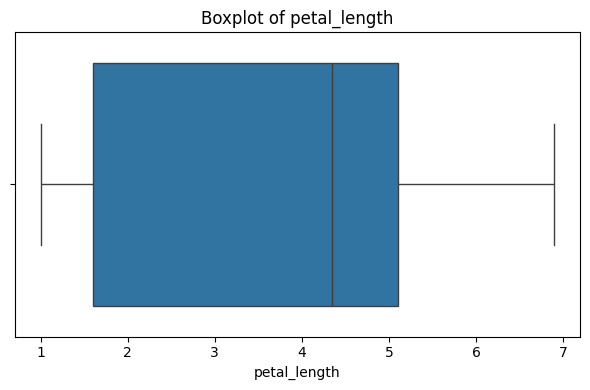

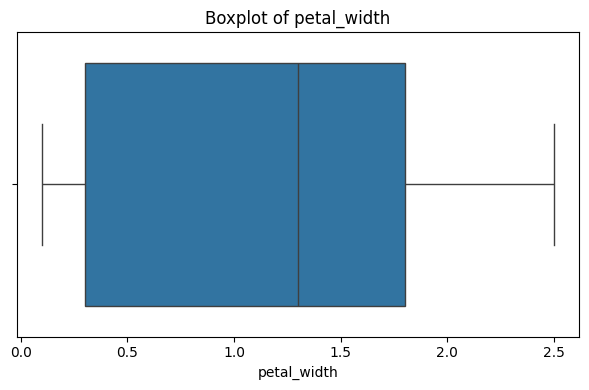

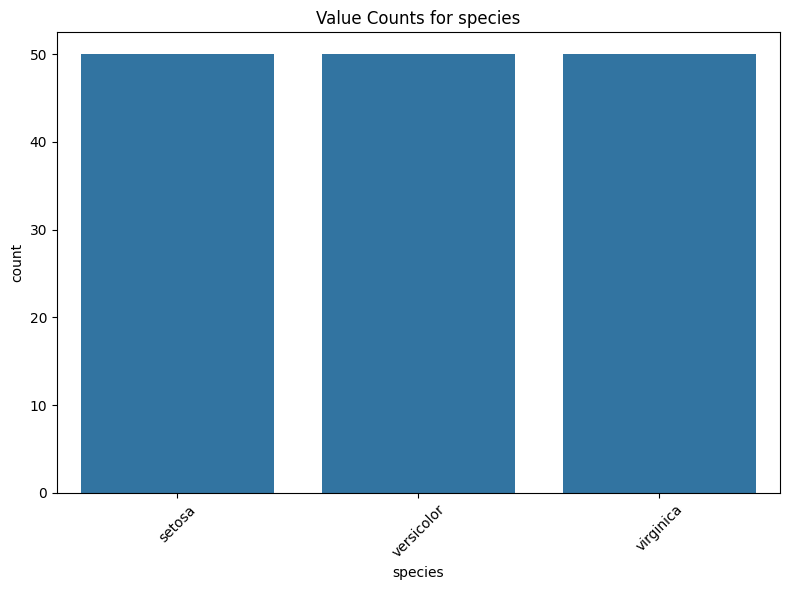

No missing values to handle.

Outlier Detection Results:
     Column  Outlier Count  Outlier %
sepal_width              4       2.67

Scaling data using RobustScaler
Reason: Outliers detected in 1 columns

Encoding Categorical Columns...
One-hot encoded 'species' with 3 unique values

RECOMMENDATIONS
Feature Selection Methods: ['Recursive Feature Elimination (RFE) with SVM or Random Forest', 'Sequential Feature Selector (SFS)', 'Generic Univariate Feature Selection']
Modeling Techniques: ['SVM (SVC / SVR)', 'K-Nearest Neighbors (KNN)', 'Linear / Logistic Regression', 'Ridge Regression', 'Random Forest', 'Gradient Boosting Machines (XGBoost, LightGBM)']
Preprocessed data saved to 'preprocessed_output.csv'
PDF report saved to 'automl_report.pdf'

Preprocessing completed successfully!
Final dataset shape: (150, 6)


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder

class DataPreprocessor:
    def __init__(self):
        self.imputer = None
        self.scaler = None
        self.encoders = {}
        self.numerical_cols = []
        self.categorical_cols = []
        
    def recommend_methods(self, n_features, n_samples, has_target):
        recommendations = {
            "feature_selection": [],
            "modeling": []
        }
        
        if not has_target:
            recommendations["feature_selection"].append("Variance Threshold")
            recommendations["feature_selection"].append("Unsupervised clustering-based selection")
            recommendations["modeling"].append("KMeans")
            recommendations["modeling"].append("PCA")
            recommendations["modeling"].append("Autoencoders")
        else:
            if n_features > 100 or n_samples > 5000:
                recommendations["feature_selection"].append("Variance Threshold")
                recommendations["feature_selection"].append("Generic Univariate Feature Selection (e.g., SelectKBest with chi2, ANOVA)")
                recommendations["feature_selection"].append("Mutual Information")
                recommendations["modeling"].append("Linear / Logistic Regression")
                recommendations["modeling"].append("Ridge Regression")
                recommendations["modeling"].append("Random Forest (for embedded feature importance)")
                recommendations["modeling"].append("XGBoost / LightGBM")
            else:
                recommendations["feature_selection"].append("Recursive Feature Elimination (RFE) with SVM or Random Forest")
                recommendations["feature_selection"].append("Sequential Feature Selector (SFS)")
                recommendations["feature_selection"].append("Generic Univariate Feature Selection")
                recommendations["modeling"].append("SVM (SVC / SVR)")
                recommendations["modeling"].append("K-Nearest Neighbors (KNN)")
                recommendations["modeling"].append("Linear / Logistic Regression")
                recommendations["modeling"].append("Ridge Regression")
                recommendations["modeling"].append("Random Forest")
                recommendations["modeling"].append("Gradient Boosting Machines (XGBoost, LightGBM)")
        
        return recommendations

    def get_dataset(self):
        try:
            dataset = input("Enter the name of the dataset file (CSV): ").strip()
            if not dataset:
                print("No filename provided.")
                return None
            df = pd.read_csv(dataset)
            print(f"Successfully loaded dataset: {dataset}")
            
            # Basic validation
            if df.empty:
                print("Warning: Dataset is empty.")
                return None
            if df.shape[1] < 2:
                print("Warning: Dataset has less than 2 columns.")
                return None
                
            return df
        except FileNotFoundError:
            print("File not found. Please check the filename and path.")
        except pd.errors.EmptyDataError:
            print("Error: The file is empty.")
        except pd.errors.ParserError:
            print("Error: Unable to parse the CSV file. Please check the format.")
        except Exception as e:
            print(f"An error occurred while loading the dataset: {e}")
        return None

    def detect_target_column(self, df):
        """Auto-detect target column based on heuristics."""
        if df is None or df.empty:
            return None
            
        common_targets = ['target', 'label', 'class', 'species', 'outcome', 'y']
        
        # Check for common target names (case-insensitive)
        for col in df.columns:
            if col.lower() in common_targets:
                print(f"Auto-detected target column: '{col}'")
                return col
        
        categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
        if len(categorical_cols) == 1:
            print(f"Auto-detected target column: '{categorical_cols[0]}' (only categorical column)")
            return categorical_cols[0]
        
        if len(categorical_cols) > 1:
            unique_counts = df[categorical_cols].nunique()
            target_candidate = unique_counts.idxmin()
            print(f"Auto-detected target column: '{target_candidate}' (categorical with least unique values)")
            return target_candidate
        
        print(f"Defaulting to last column as target: '{df.columns[-1]}'")
        return df.columns[-1]

    def sanity_check(self, df):
        if df is None:
            print("Data doesn't exist.")
            return False
        
        if df.empty:
            print("Dataset is empty.")
            return False
            
        try:
            print("\nDATA SANITY CHECK REPORT")
            print(f"Shape of the dataset: {df.shape}")
            print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
            print("\nDataset Info:")
            df.info()
            
            print("\nMissing Values Analysis:")
            missing_percent = (df.isnull().sum() / df.shape[0] * 100).round(2)
            missing_data = pd.DataFrame({
                'Column': missing_percent.index,
                'Missing Count': df.isnull().sum(),
                'Missing %': missing_percent
            })
            missing_data = missing_data[missing_data['Missing Count'] > 0]
            if len(missing_data) > 0:
                print(missing_data.to_string(index=False))
            else:
                print("No missing values found.")
            
            duplicate_count = df.duplicated().sum()
            print(f"\nDuplicate rows: {duplicate_count}")
            if duplicate_count > 0:
                print(f"({duplicate_count/len(df)*100:.2f}% of total data)")
            
            # Check for constant columns
            constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
            if constant_cols:
                print(f"\nConstant columns (consider removing): {constant_cols}")
            
            return True
        except Exception as e:
            print(f"Error during sanity check: {e}")
            return False

    def check_categorical_distributions(self, df):
        if df is None or df.empty:
            return
        obj_cols = df.select_dtypes(include=["object", "category"]).columns
        if len(obj_cols) == 0:
            print("No categorical columns found.")
            return
        print("\nCATEGORICAL DISTRIBUTIONS")
        for col in obj_cols:
            unique_vals = df[col].nunique()
            print(f"\n'{col}' — {unique_vals} unique value(s)")
            if unique_vals <= 15:
                print(df[col].value_counts(dropna=False).head(10))
            else:
                print("High cardinality - showing top 5 values:")
                print(df[col].value_counts().head(5))

    def eda_summary(self, df):
        if df is None or df.empty:
            print("Data doesn't exist.")
            return
    
        try:
            show_graphs = input("Would you like to see EDA graphs? (yes/no): ").lower().strip()
            show_graphs = show_graphs in ["yes", "y"]
    
            print("\nEXPLORATORY DATA ANALYSIS")
    
            numerical_cols = df.select_dtypes(include=[np.number]).columns
            if len(numerical_cols) > 0:
                print("\nNumerical Columns Summary:")
                print(df[numerical_cols].describe().round(2))
    
            categorical_cols = df.select_dtypes(include=["object", "category"]).columns
            if len(categorical_cols) > 0:
                print("\nCategorical Columns Summary:")
                print(df[categorical_cols].describe())
    
            if show_graphs and len(numerical_cols) > 0:
                print("\nDisplaying EDA graphs...")
                os.makedirs("eda_plots", exist_ok=True)
    
                # Histograms for numericals
                for col in numerical_cols:
                    plt.figure(figsize=(6, 4))
                    sns.histplot(df[col].dropna(), kde=True, bins=30)
                    plt.title(f"Distribution of {col}")
                    plt.tight_layout()
                    plt.savefig(f"eda_plots/hist_{col}.png", dpi=150, bbox_inches='tight')
                    plt.show()
    
                # Boxplots for numericals
                for col in numerical_cols:
                    plt.figure(figsize=(6, 4))
                    sns.boxplot(x=df[col])
                    plt.title(f"Boxplot of {col}")
                    plt.tight_layout()
                    plt.savefig(f"eda_plots/box_{col}.png", dpi=150, bbox_inches='tight')
                    plt.show()
    
            if show_graphs and len(categorical_cols) > 0:
                # Count plots for categoricals
                for col in categorical_cols:
                    plt.figure(figsize=(8, 6))
                    top_categories = df[col].value_counts().head(10).index
                    df_filtered = df[df[col].isin(top_categories)]
                    sns.countplot(data=df_filtered, x=col, order=top_categories)
                    plt.title(f"Value Counts for {col}")
                    plt.xticks(rotation=45)
                    plt.tight_layout()
                    plt.savefig(f"eda_plots/count_{col}.png", dpi=150, bbox_inches='tight')
                    plt.show()
    
        except Exception as e:
            print(f"Exception occurred during EDA: {e}")

    def handle_missing_values(self, df):
        if df is None or df.empty:
            return df
        if df.isnull().sum().sum() == 0:
            print("No missing values to handle.")
            return df
            
        print("\nHandling Missing Values...")
        self.numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        self.categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
        df_processed = df.copy()
        
        if self.numerical_cols:
            num_imputer = SimpleImputer(strategy='median')
            df_processed[self.numerical_cols] = num_imputer.fit_transform(df[self.numerical_cols])
            print(f"Imputed {len(self.numerical_cols)} numerical columns with median")
        
        if self.categorical_cols:
            cat_imputer = SimpleImputer(strategy='most_frequent')
            df_processed[self.categorical_cols] = cat_imputer.fit_transform(df[self.categorical_cols])
            print(f"Imputed {len(self.categorical_cols)} categorical columns with mode")
        
        return df_processed

    def detect_and_report_outliers(self, df):
        outlier_summary = []
        numerical_cols = df.select_dtypes(include=[np.number]).columns
        
        for col in numerical_cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            outlier_percentage = len(outliers) / len(df) * 100
            if outlier_percentage > 1:
                outlier_summary.append({
                    'Column': col,
                    'Outlier Count': len(outliers),
                    'Outlier %': round(outlier_percentage, 2)
                })
        
        if outlier_summary:
            print("\nOutlier Detection Results:")
            outlier_df = pd.DataFrame(outlier_summary)
            print(outlier_df.to_string(index=False))
            return [item['Column'] for item in outlier_summary]
        else:
            print("No significant outliers found.")
            return []

    def choose_and_apply_scaler(self, df):
        numerical_cols = df.select_dtypes(include=[np.number]).columns
        if len(numerical_cols) == 0:
            print("No numerical columns to scale.")
            return df
        
        outlier_cols = []
        sparse_cols = []
        
        for col in numerical_cols:
            Q1, Q3 = df[col].quantile([0.25, 0.75])
            IQR = Q3 - Q1
            outliers = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).sum()
            if outliers > len(df) * 0.01:
                outlier_cols.append(col)
            
            zero_ratio = (df[col] == 0).sum() / len(df)
            if zero_ratio > 0.5:
                sparse_cols.append(col)
        
        # Choose scaler based on data characteristics
        if len(outlier_cols) > 0:
            scaler_choice = "RobustScaler"
            self.scaler = RobustScaler()
        elif len(sparse_cols) > 0:
            scaler_choice = "MaxAbsScaler"
            self.scaler = MaxAbsScaler()
        else:
            scaler_choice = "StandardScaler"
            self.scaler = StandardScaler()
        
        print(f"\nScaling data using {scaler_choice}")
        if len(outlier_cols) > 0:
            print(f"Reason: Outliers detected in {len(outlier_cols)} columns")
        elif len(sparse_cols) > 0:
            print(f"Reason: Sparse data detected in {len(sparse_cols)} columns")
        else:
            print("Reason: Standard normal distribution assumed")
            
        df_scaled = df.copy()
        df_scaled[numerical_cols] = self.scaler.fit_transform(df[numerical_cols])
        return df_scaled

    def encode_categorical(self, df):
        df_encoded = df.copy()
        self.categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
        
        if len(self.categorical_cols) == 0:
            print("No categorical columns to encode.")
            return df_encoded
        
        print("\nEncoding Categorical Columns...")
        for col in self.categorical_cols:
            unique_vals = df[col].nunique()
            if unique_vals <= 2:
                le = LabelEncoder()
                df_encoded[col] = le.fit_transform(df[col])
                self.encoders[col] = le
                print(f"Label encoded '{col}' (binary)")
            elif unique_vals > 20:
                print(f"Warning: '{col}' has {unique_vals} unique values. Consider target encoding or other methods.")
                # For now, still use one-hot encoding but with a warning
                ohe = OneHotEncoder(sparse_output=False, drop='first')
                transformed = ohe.fit_transform(df[[col]])
                new_cols = [f"{col}_{cat}" for cat in ohe.categories_[0][1:]]
                df_ohe = pd.DataFrame(transformed, columns=new_cols, index=df.index)
                df_encoded = pd.concat([df_encoded.drop(columns=[col]), df_ohe], axis=1)
                self.encoders[col] = ohe
                print(f"One-hot encoded '{col}' with {unique_vals} unique values (high cardinality)")
            else:
                ohe = OneHotEncoder(sparse_output=False, drop='first')
                transformed = ohe.fit_transform(df[[col]])
                new_cols = [f"{col}_{cat}" for cat in ohe.categories_[0][1:]]
                df_ohe = pd.DataFrame(transformed, columns=new_cols, index=df.index)
                df_encoded = pd.concat([df_encoded.drop(columns=[col]), df_ohe], axis=1)
                self.encoders[col] = ohe
                print(f"One-hot encoded '{col}' with {unique_vals} unique values")
        
        return df_encoded

    def generate_pdf_report(self, df_summary_text="Preprocessing Report", plot_dir="eda_plots"):
        try:
            from fpdf import FPDF
            pdf = FPDF()
            pdf.set_auto_page_break(auto=True, margin=15)
            pdf.add_page()
            pdf.set_font("Arial", size=12)
        
            pdf.cell(200, 10, txt="AutoML Preprocessing Report", ln=True, align='C')
            pdf.ln(10)
            pdf.multi_cell(0, 10, df_summary_text)
        
            if os.path.exists(plot_dir):
                plot_files = sorted([f for f in os.listdir(plot_dir) if f.endswith('.png')])
                for plot in plot_files:
                    try:
                        pdf.add_page()
                        pdf.image(os.path.join(plot_dir, plot), w=180)
                    except Exception as e:
                        print(f"Could not add plot {plot} to PDF: {e}")
        
            pdf.output("automl_report.pdf")
            print("PDF report saved to 'automl_report.pdf'")
        except ImportError:
            print("fpdf not installed. Skipping PDF report generation.")
            print("Install with: pip install fpdf")
        except Exception as e:
            print(f"Error generating PDF report: {e}")

    def preprocess(self, df):
        if df is None or df.empty:
            print("Cannot preprocess: dataset is None or empty")
            return None, None
        
        try:
            target_col = self.detect_target_column(df)
            if target_col is None:
                print("Could not detect target column")
                return None, None
                
            features = df.drop(columns=[target_col])
            target = df[target_col]

            print(f"\nTarget column detected: '{target_col}'")
            print(f"Number of features: {features.shape[1]}, Number of samples: {df.shape[0]}")

            if not self.sanity_check(df):
                return None, None
            
            self.check_categorical_distributions(df)
            self.eda_summary(df)

            df_imputed = self.handle_missing_values(df)
            outlier_cols = self.detect_and_report_outliers(df_imputed)
            df_scaled = self.choose_and_apply_scaler(df_imputed)
            df_encoded = self.encode_categorical(df_scaled)

            has_target = target_col is not None and target_col in df.columns
            recs = self.recommend_methods(
                n_features=features.shape[1],
                n_samples=df.shape[0],
                has_target=has_target
            )
            
            print("\nRECOMMENDATIONS")
            print(f"Feature Selection Methods: {recs['feature_selection']}")
            print(f"Modeling Techniques: {recs['modeling']}")

            # Save preprocessed data
            df_encoded.to_csv("preprocessed_output.csv", index=False)
            print("Preprocessed data saved to 'preprocessed_output.csv'")

            # Generate report text
            summary = f"""
            Dataset Shape: {df.shape}
            Target Column: {target_col}
            Features: {df.shape[1]-1}
            Samples: {df.shape[0]}
            Missing Values Handled: {'Yes' if df.isnull().sum().sum() > 0 else 'No'}
            Outlier Columns: {len(outlier_cols)}
            Scaler Used: {type(self.scaler).__name__ if self.scaler else 'None'}
            Categorical Columns Encoded: {len(self.categorical_cols)}
            Feature Selection Recommendations: {', '.join(recs['feature_selection'])}
            Model Recommendations: {', '.join(recs['modeling'])}
            """
            
            self.generate_pdf_report(df_summary_text=summary)
            
            return df_encoded, target_col
            
        except Exception as e:
            print(f"Error during preprocessing: {e}")
            return None, None


# Usage example:
if __name__ == "__main__":
    dp = DataPreprocessor()
    df = dp.get_dataset() 
    if df is not None:
        processed_df, target_col = dp.preprocess(df)
        if processed_df is not None:
            print(f"\nPreprocessing completed successfully!")
            print(f"Final dataset shape: {processed_df.shape}")
        else:
            print("Preprocessing failed.")
    else:
        print("Could not load dataset.")